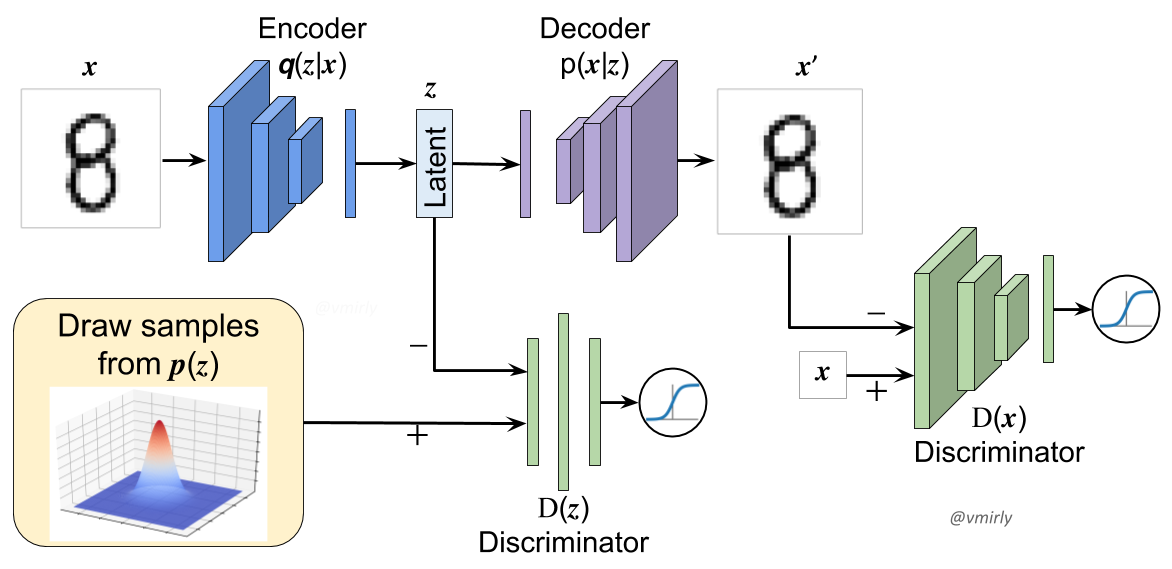

In [2]:
from IPython.display import Image
Image("figs/adversarial-autoencoder-double-discriminator.png")

Ref: 
 * **Adversarial Autoencoders**, by A. Makhzani, J. Shlens, N. Jaitly, I. Goodfellow, and B. Frey [Link to Publication](https://arxiv.org/abs/1511.05644)
 * **Generative Probabilistic Novelty Detection with Adversarial Autoencoders**, by S. Pidhorskyi, R. Almohsen, D.A. Adjeroh, and G. Doretto [Link to Publicaiton](https://arxiv.org/abs/1807.02588)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
## Settings:

# CUDA Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
num_epochs = 20
batch_size = 128
learning_rate = 0.001
lambda_gp = 10.0
lambda_rec = 1.0
lambda_src = 2.0
n_critics = 2

# Model Parameters
image_size = 28
dim_in = 1
conv_dim = 32
n_conv_layers = 3
num_hidden_disc_z = 5
num_latent = 20
num_logits_disc_z = 2


Device: cuda:0


In [3]:
## MNIST Data Loader

train_dataset = datasets.MNIST(root='./mnist/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_dataset = datasets.MNIST(root='./mnist/', 
                              train=False, 
                              transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
images, labels = next(iter(train_loader))
print('Images dimension:', images.shape)
print('Labels dimension:', labels.shape)


Images dimension: torch.Size([128, 1, 28, 28])
Labels dimension: torch.Size([128])


# Class for Adversarial Autoencoder

In [4]:
###### MODEL: Generator ######

class Autoencoder(nn.Module):
    """Serves as the generator network (G)"""
    def __init__(self, image_size, dim_in, dim_conv, n_conv_layers=3, num_latent=20):
        super(Autoencoder, self).__init__()
        
        ## >> Encoder
        layers = []
        layers.append(nn.Conv2d(dim_in, conv_dim, kernel_size=5, stride=1, padding=2, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))
        
        curr_dim = conv_dim
        for i in range(1, n_conv_layers):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2
        
        self.encoder = nn.Sequential(*layers)
        
        self.image_downsize = int(image_size / np.power(2, n_conv_layers-1))
        features_size = curr_dim*self.image_downsize*self.image_downsize
        self.fc_encoder = nn.Linear(features_size, num_latent)
        
        ## >> Decoder
        self.fc_decoder = nn.Linear(num_latent, features_size)
        
        layers = []        
        for i in range(1, n_conv_layers):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2
            
        layers.append(nn.Conv2d(curr_dim, dim_in, kernel_size=5, stride=1, padding=2, bias=False))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x, from_latent=False, return_mode='both'):
        """return_mode: [
            'latent': will return the latent vector (z)
            'logits': will return the final reconstruction logits
            'output': will return the final output after applying sigmoid
            ]
        """
        if not from_latent:
            x = self.encoder(x)
            x = x.view(-1, np.prod(x.shape[1:]))
            z = self.fc_encoder(x)
            if return_mode == 'latent':
                return z
        else:
            z = x
        
        x = self.fc_decoder(z)
        x = x.view(-1, x.shape[1]//(self.image_downsize**2), 
                   self.image_downsize, self.image_downsize)
        if return_mode == 'logits':
            return z, self.decoder(x)
        elif return_mode == 'output':
            return torch.sigmoid(self.decoder(x))

###### MODEL: Discriminator ######

class DiscriminatorLatent(nn.Module):
    """Discriminator network for the latent space (D_z)"""
    def __init__(self, num_ae_latent=20, num_hidden=64, num_logits=5):
        super(DiscriminatorLatent, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(num_ae_latent, num_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(num_hidden, num_logits))
        
    def forward(self, x):
        return self.main(x)

class DiscriminatorImage(nn.Module):
    """Discriminator network for the image space (D_x)"""
    def __init__(self, image_size, dim_in, dim_conv, n_conv_layers=3):
        super(DiscriminatorImage, self).__init__()
        layers = []
        layers.append(nn.Conv2d(dim_in, conv_dim, kernel_size=5, stride=1, padding=1))
        layers.append(nn.LeakyReLU(0.01, inplace=True))

        curr_dim = conv_dim
        for i in range(1, n_conv_layers):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01, inplace=True))
            curr_dim = curr_dim * 2

        #kernel_size = int(image_size / np.power(2, n_conv_layers))
        nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.main = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.main(x)


# Solver class

In [5]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2"""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)


class Solver():
    def __init__(self, image_size, dim_in, conv_dim, n_conv_layers, num_latent,
                 n_critics, num_hidden_disc_z, num_logits_disc_z, 
                 lambda_src, lambda_gp, learning_rate, device):
        self.image_size = image_size
        self.dim_in = dim_in
        self.conv_dim = conv_dim
        self.n_conv_layers = n_conv_layers
        self.num_latent = num_latent
        self.n_critics = n_critics
        self.num_hidden_disc_z = num_hidden_disc_z
        self.num_logits_disc_z = num_logits_disc_z
        #self.conv_dim_disc_x = conv_dim_disc_x
        
        self.lambda_src = lambda_src
        self.lambda_gp = lambda_gp
        self.learning_rate = learning_rate
        self.device = device
        
        self.build_model()
        
    def build_model(self):
        self.G = Autoencoder(self.image_size, self.dim_in, self.conv_dim, 
                             self.n_conv_layers, self.num_latent)
        self.Dz = DiscriminatorLatent(self.num_latent, self.num_hidden_disc_z, 
                                      self.num_logits_disc_z)
        self.Dx = DiscriminatorImage(self.image_size, self.dim_in, 
                                     self.conv_dim, self.n_conv_layers)
        
        self.G = self.G.to(self.device)
        self.Dz = self.Dz.to(self.device)
        self.Dx = self.Dx.to(self.device)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=self.learning_rate)
        self.dz_optimizer = torch.optim.Adam(self.Dz.parameters(), lr=self.learning_rate)
        self.dx_optimizer = torch.optim.Adam(self.Dx.parameters(), lr=self.learning_rate)

    def reset_grads(self):
        """A helper function to reset gradient buffers"""
        self.g_optimizer.zero_grad()
        self.dz_optimizer.zero_grad()
        self.dx_optimizer.zero_grad()

    def train(self, train_loader, num_epochs=10):
        #======================================================= #
        #                       Training                         #
        #======================================================= #

        for epoch in range(num_epochs):
            for batch_idx, (images, labels) in enumerate(train_loader):

                images = images.to(self.device)

                # ======================================================= #
                #                 1. Train the discriminators             #
                # ======================================================= #
                ## >> Latent-level Discriminator
                z_real = torch.randn(images.size(0), num_latent).to(self.device)
                out_real_z = self.Dz(z_real)
                dz_loss_real = -torch.mean(out_real_z)

                z_fake = self.G(images, return_mode='latent')
                out_fake_z = self.Dz(z_fake)
                dz_loss_fake = torch.mean(out_fake_z)

                alpha = torch.rand(z_real.size(0), 1).to(self.device)
                z_fake_hat = (alpha * z_real.detach() + (1 - alpha) * z_fake.detach()).requires_grad_(True)
                out_fake_hat_z = self.Dz(z_fake_hat)
                dz_loss_gp = gradient_penalty(out_fake_hat_z, z_fake_hat)

                dz_loss = (lambda_src*(dz_loss_real + dz_loss_fake) + 
                          lambda_gp*dz_loss_gp)

                self.reset_grads()
                dz_loss.backward()
                self.dz_optimizer.step()

                ## >> Image-level Discriminator
                out_real_x = self.Dx(images)
                dx_loss_real = -torch.mean(out_real_x)

                x_fake = self.G(images, return_mode='output')
                out_fake_x = self.Dx(x_fake)
                dx_loss_fake = torch.mean(out_fake_x)

                ## >> gradient-penalty
                alpha = torch.rand(images.size(0), 1, 1, 1).to(self.device)
                x_fake_hat = (alpha * images.detach() + (1 - alpha) * x_fake.detach()).requires_grad_(True)
                out_fake_hat_x = self.Dx(x_fake_hat)
                dx_loss_gp = gradient_penalty(out_fake_hat_x, x_fake_hat)

                dx_loss = (lambda_src*(dx_loss_real + dx_loss_fake) + 
                          lambda_gp*dx_loss_gp)

                self.reset_grads()
                dx_loss.backward()
                self.dx_optimizer.step()
                
                

                # ======================================================= #
                #                2. Train the generator (AE)              #
                # ======================================================= #
                if batch_idx % self.n_critics == 0:
                    z_fake, x_rec = self.G(images, return_mode='logits')
                    out_fake_z = self.Dz(z_fake)
                    g_loss_fake_z = -torch.mean(out_fake_z)
                    
                    out_fake_x = self.Dx(torch.sigmoid(x_rec))
                    g_loss_fake_x = -torch.mean(out_fake_x)

                    g_loss_rec = F.binary_cross_entropy_with_logits(
                                x_rec, images, reduction='sum') / images.size(0)

                    g_loss = (lambda_src*(g_loss_fake_z + g_loss_fake_x) + 
                              lambda_rec*g_loss_rec)

                    self.reset_grads()
                    g_loss.backward()
                    self.g_optimizer.step()

                if not batch_idx % 200:
                    print ('Epoch: {:03d} Iter {:03d}/{:03d} |'.format(
                           epoch+1, batch_idx, len(train_dataset)//batch_size), end=' ')
                    print('G-loss: {:.3f} {:.3f} {:.3f} | Dz-loss: {:.3f} {:.3f} {:.3f}'.format(
                           g_loss_fake_z, g_loss_fake_z, g_loss_rec, 
                           dz_loss_real, dz_loss_fake, dz_loss_gp), end=' ')
                    print(' | Dx-loss: {:.3f} {:.3f} {:.3f}'.format(
                           dz_loss_real, dz_loss_fake, dz_loss_gp))



# Training

In [6]:

torch.manual_seed(random_seed)


aae_solver = Solver(image_size, dim_in, conv_dim, n_conv_layers, num_latent,
                 n_critics, num_hidden_disc_z, num_logits_disc_z,  
                 lambda_src, lambda_gp, learning_rate, device)

aae_solver.train(train_loader, num_epochs)

Epoch: 001 Iter 000/468 | G-loss: -0.031 -0.031 570.542 | Dz-loss: -0.068 0.031 0.516  | Dx-loss: -0.068 0.031 0.516
Epoch: 001 Iter 200/468 | G-loss: 2.419 2.419 132.073 | Dz-loss: -0.009 -2.334 0.248  | Dx-loss: -0.009 -2.334 0.248
Epoch: 001 Iter 400/468 | G-loss: 0.059 0.059 88.534 | Dz-loss: -0.301 -0.057 0.644  | Dx-loss: -0.301 -0.057 0.644
Epoch: 002 Iter 000/468 | G-loss: 0.047 0.047 80.251 | Dz-loss: -0.516 -0.046 0.600  | Dx-loss: -0.516 -0.046 0.600
Epoch: 002 Iter 200/468 | G-loss: -0.045 -0.045 75.718 | Dz-loss: -0.677 0.047 0.626  | Dx-loss: -0.677 0.047 0.626
Epoch: 002 Iter 400/468 | G-loss: -0.051 -0.051 68.575 | Dz-loss: -1.253 0.052 0.459  | Dx-loss: -1.253 0.052 0.459
Epoch: 003 Iter 000/468 | G-loss: -0.013 -0.013 68.136 | Dz-loss: -1.492 0.013 0.394  | Dx-loss: -1.492 0.013 0.394
Epoch: 003 Iter 200/468 | G-loss: -0.590 -0.590 69.473 | Dz-loss: -2.528 0.589 0.038  | Dx-loss: -2.528 0.589 0.038
Epoch: 003 Iter 400/468 | G-loss: -2.351 -2.351 73.228 | Dz-loss: -2.6

# Evaluation

## Part-1: Evaluation based on input

torch.Size([128, 1, 28, 28])
torch.Size([20, 1, 28, 28])


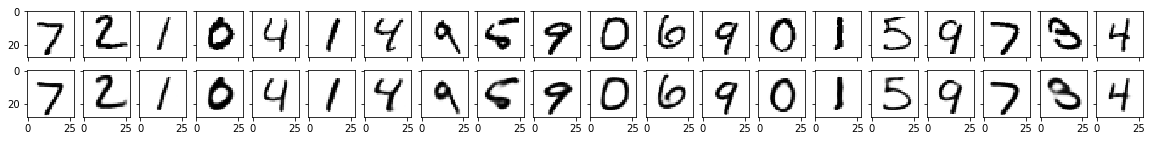

In [10]:

%matplotlib inline
import matplotlib.pyplot as plt

G = aae_solver.G

n_images = 20

images, labels = next(iter(test_loader))
print(images.shape)
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2))
input_images = images[:n_images]
print(input_images.shape)
outputs = G(input_images.to(device), return_mode='output')
output_images = outputs.cpu()

for i in range(n_images):
    for ax, img in zip(axes, [input_images, output_images]):
        ax[i].imshow(img[i].detach().reshape((image_width, image_width)), cmap='binary')

## Part-2: Evalaution based on latent space sampled from $p(z)$

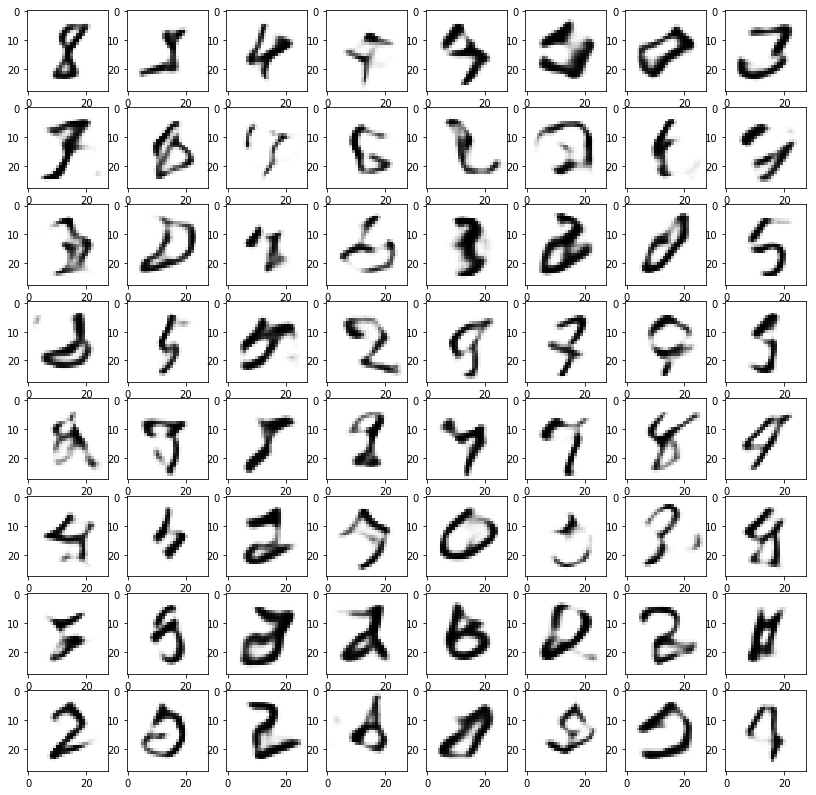

In [11]:
n_images = 64
latent = torch.randn(n_images, num_latent).to(device)

outputs = G(latent, from_latent=True, return_mode='output')

fig = plt.figure(figsize=(14, 14))
for i in range(n_images):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(outputs[i].detach().reshape((image_width, image_width)), cmap='binary')